# XAI CODE DEMO

## Explainable AI Specialization on Coursera

# Counterfactual Explanations 👾

If you experience high latency while running this notebook, you can open it in Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/explainable-machine-learning/explainable-ml/blob/main/counterfactul_explanations.ipynb)

We can simulate counterfactuals for predictions of ML models by changing the feature values of an instance before making the predictions and analyzing how the prediction changes.

A counterfactual explanation of a prediction describes the smallest change to the feature values that changes the prediction to a predefined output

We can use an optimization algorithm to minimize loss:
* Define a loss function
* This loss takes as input the instance of interest, a counterfactual and the desired (counterfactual) outcome
* Find the counterfactual explanation that minimizes this loss using an optimization algorithm.
* There are MANY methods for this, which differ in their definition of the loss function and optimization method

In this tutorial we will show an implementation of counterfactuals from the python library `alibi`.

The loss function used by `alibi`:

$$
    \mathcal{L}(X' | X) = (f_t(X') - p_t) + \lambda L_1(X', X)
$$

`L(X'|X) = (ft(X')-pt) + λL1(X',X)`

The first loss term, guides the search towards instances X' for which the predicted class probability ft(X') is close to a pre-specified target class probability pt. The second loss term ensures that the counterfactuals are close in the feature space to the original test instance.


This tutorial was adapted from the [`alibi`](https://docs.seldon.io/projects/alibi/en/stable/examples/cf_mnist.html)library documentation



---




In [1]:
!pip install numpy==1.25.2 pandas==2.0.3 matplotlib==3.7.1 scikit-learn==1.2.2 tensorflow==2.14.1 alibi[tensorflow]==0.9.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 21.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 121.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 143.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 139.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 179.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

Note: When you run the code block below, you may get a warning "Cannot find TensorRT". Don't worry about this, it is only required if you need a GPU, which this lab does not need.

In [2]:
# Basic
import os
import numpy as np
import matplotlib.pyplot as plt

# Data + Model
import tensorflow as tf
tf.get_logger().setLevel(40)
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

# XAI
from alibi.explainers import Counterfactual

2024-12-04 21:32:18.429378: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 21:32:18.495801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 21:32:18.495857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 21:32:18.495970: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 21:32:18.520840: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 21:32:18.521677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Data and Model

### Dataset

We are going to use the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist) from the tensorflow library.

11490434/11490434 [==============================] - 0s 0us/step


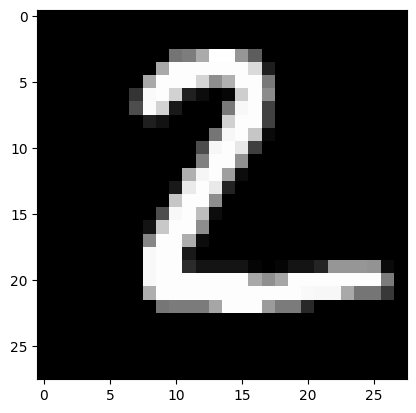

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Show image from test dataset
plt.gray()
plt.imshow(x_test[1]);

### Data Preprocessing

* Reshape data
* Categorize data labels
* Scale the data

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape data
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))

# Categorize data labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
# Scale data
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

### Simple CNN

This is a simple CNN architecture for example purposes. I encourage you to try out different architectures!

In [6]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

### Train and Save CNN Model

Train model. For runtime speed, train for 3 epochs. In practice, apply regularization techniques like early stopping.

In [7]:
# Initialize Model
cnn = cnn_model()
# Print Model Summary
cnn.summary()
# Fit Model
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
# Save Model
cnn.save('mnist_cnn.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                        

2024-12-04 21:32:24.057030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-12-04 21:32:24.089463: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/bias/v/Assign' id:494 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Evaluate CNN Model on Test Data

In [8]:
# Load Model
cnn = load_model('mnist_cnn.h5')
# Evaluate Model on Test Set and Print Test Accuracy
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

2024-12-04 21:35:42.565776: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_1/bias/Assign' id:721 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1_1/bias, dense_1_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:35:42.760344: W tensorflow/c/c_api.cc:305] Operation '{name:'conv2d_1_1/kernel/v/Assign' id:923 op device:{requested: '', assigned: ''} def:{{{node conv2d_1_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_1_1/kernel/v, conv2d_1_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tr

Test accuracy:  0.9872


## Counterfactual Explanation

### Define sample of interest

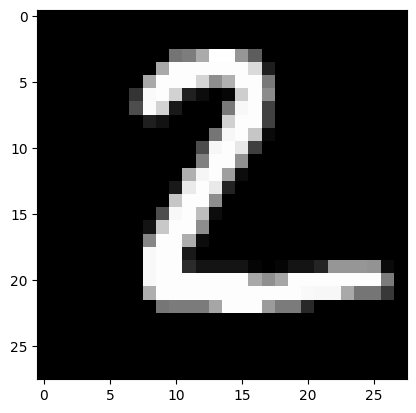

In [9]:
X = x_test[1].reshape((1,) + x_test[1].shape)
plt.imshow(X.reshape(28, 28));

### Set parameters for counterfactual explainer

* `target_proba`: This parameter specifies the desired probability of the target class in the generated counterfactual explanation. In this case, it's set to 1.0, meaning the desired probability of the target class is 100%.
* `tol`: Tolerance. Threshold that indicates how close the probability of the target class in the generated counterfactual explanation needs to be to target_proba. Here, it's set to 0.01, meaning the probability of the target class should be within 1% of the desired probability.
* `target_class`: Specifies the class for which the counterfactual explanation is generated. In this case, it's set to 'other', indicating that any class other than class 2 will work.
* `max_iter`: Maximum number of iterations for the optimization algorithm. If the algorithm doesn't converge within this number of iterations, it stops.
* `lam_init`: Initial value for the regularization parameter lambda used in the optimization algorithm. This parameter controls the trade-off between fidelity to the original input and sparsity of the counterfactual explanation.
* `max_lam_steps`: Maximum number of steps for adjusting the regularization parameter lambda during optimization. If the optimization doesn't converge within these steps, it stops.
* `learning_rate_init`: Initial learning rate for the optimization algorithm. This parameter controls the step size taken in the direction of the gradient during optimization.
* `feature_range`: Specifies the range of values for the features of the input data. It's a tuple containing the minimum and maximum values observed in the training data x_train. This range is likely used to ensure that the generated counterfactual explanations are within reasonable bounds of the original data.



In [10]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01
target_class = 'other'
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

### Initialize the counterfactual explainer

In [11]:
# initialize explainer
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = cf.explain(X)

2024-12-04 21:35:45.611347: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_1/Softmax' id:727 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Show counterfactual

Counterfactual prediction: 1 with probability 0.9922897219657898


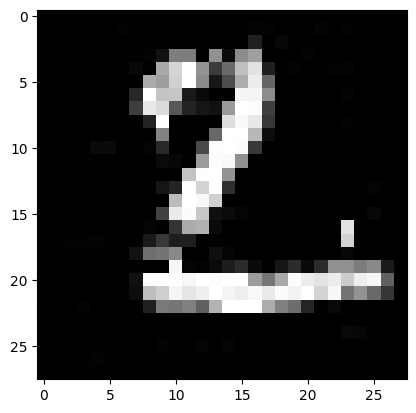

In [12]:
# Get the predicted class of the counterfactual example
pred_class = explanation.cf['class']

# Get the probability of the predicted class from the counterfactual explanation
proba = explanation.cf['proba'][0][pred_class]

# Print the predicted class and its probability
print(f'Counterfactual prediction: {pred_class} with probability {proba}')

# Display the counterfactual example image
plt.imshow(explanation.cf['X'].reshape(28, 28));


### Illustration of counterfactual evolution

The evolution of the counterfactual during the iterations over λ:

Typically, the first few iterations find counterfactuals that are out of distribution, while the later iterations make the counterfactual more sparse and interpretable.

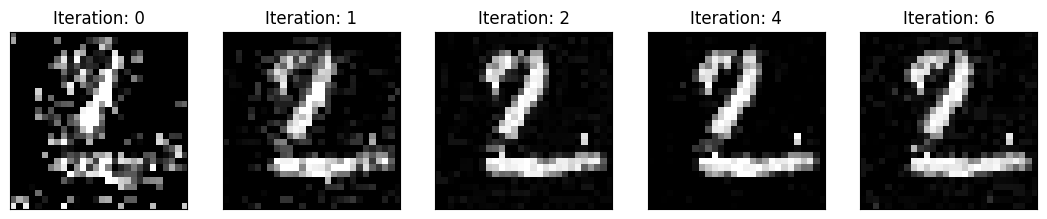

In [13]:
# Calculate the number of counterfactuals for each iteration in the range of max_lam_steps
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)])

# Initialize an empty dictionary to store examples with counterfactuals
examples = {}

# Loop through each iteration and count the number of counterfactuals
for ix, n in enumerate(n_cfs):
    if n > 0:  # Check if there are counterfactuals for this iteration
        # Store the example details in the dictionary
        examples[ix] = {
            'ix': ix,  # Index of the iteration
            'lambda': explanation.all[ix][0]['lambda'],  # Lambda value for the iteration
            'X': explanation.all[ix][0]['X']  # Counterfactual example (image data)
        }

# Determine the layout for the subplot grid
columns = len(examples) + 1  # Number of columns is one more than the number of examples
rows = 1  # Only one row is needed

# Create a figure with a specified size
fig = plt.figure(figsize=(16, 6))

# Loop through the examples to create subplots for each
for i, key in enumerate(examples.keys()):
    # Create a subplot for each example
    ax = plt.subplot(rows, columns, i + 1)
    # Hide the x and y axis labels
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display the counterfactual example image
    plt.imshow(examples[key]['X'].reshape(28, 28))
    # Set the title of the subplot to indicate the iteration number
    plt.title(f'Iteration: {key}')

### Set target class for counterfactual

In [14]:
# Set target class
target_class = 6

# initialize explainer
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = cf.explain(X)

2024-12-04 21:35:53.754859: W tensorflow/c/c_api.cc:305] Operation '{name:'cf_search/cf_search/counterfactual/Adam_1/Assign' id:1425 op device:{requested: '', assigned: ''} def:{{{node cf_search/cf_search/counterfactual/Adam_1/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@cf_search/counterfactual"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](cf_search/cf_search/counterfactual/Adam_1, cf_search/cf_search/counterfactual/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Counterfactual prediction: 6 with probability 0.9933254718780518


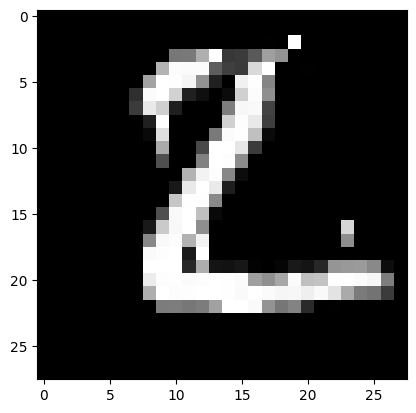

In [15]:
# Get the predicted class of the counterfactual example
pred_class = explanation.cf['class']

# Get the probability of the predicted class from the counterfactual explanation
proba = explanation.cf['proba'][0][pred_class]

# Print the predicted class and its probability
print(f'Counterfactual prediction: {pred_class} with probability {proba}')

# Display the counterfactual example image
plt.imshow(explanation.cf['X'].reshape(28, 28));

### Plot the difference between the counterfactual and the original instance


Sometimes it is more informative to look at the difference between our instance and the counterfactual. This often is more intuitive.

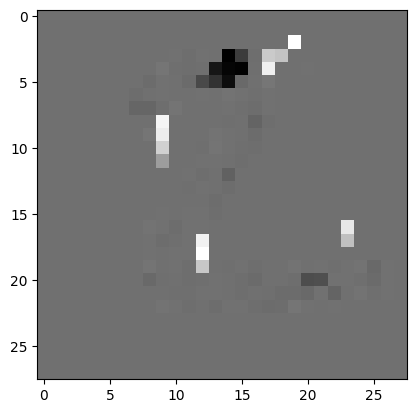

In [16]:
# Plot difference between X' and X
plt.imshow((explanation.cf['X'] - X).reshape(28, 28));